In [1]:
# GARCH: Generalized AutoRegressive Conditional Heteroskedasticity
# Heteroskedasticity:


In [2]:
# GARCH is a popular approach to model volatility. This session contains 4 chapters: 
# 1- GARCH model fundamentals: what GARCH models are, why we use them, and how to apply garch models in python. ----------
# 2- GARCH model configuration: we will dive into specific GARCH model assumptions, and learn how to define a practical 
#    model for financial time series data.
# 3- Model performance evaluation: we will learn variuos metrics we can use to assess model performance, and select a 
#    better model.
# 4- GARCH in action: we will learn some practical application of GARCH models in financial risk and portfolio managment,
#    which include calculations of value-at-risk, dynamic covariance, and stock beta. 


In [3]:
# # In ancient Greek: "di(erent" (hetero) + "dispersion" (skedasis)
# A common assumption in time series modeling is that volatility remains constant over time, however it is not always the
# case, and there is heteroskedasticity, meaning different dispersion over time, which has been frequenctly obsereved in 
# financial return data. Volatility tends to increase or decrease systematically over time. a strightforward way to detect
# heteroscedasticity is to plot the data and observe its behaviour over time. 

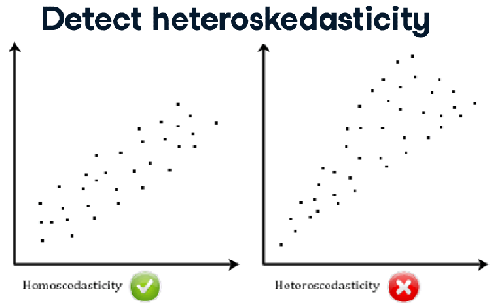

In [4]:
# VIX: Volatility index is a barometer of the US stock market expected volatility and risk sentiment.
# large price changes are very likely to be followed by more large changes and vice versa. Volatility clustering happens
# because market tend to respond to new information shocks with dramatic price movements, and it takes time for the
# shocking effect to resolve and dissipate.


In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [15]:
sp_price = pd.read_excel("F:\\schulich\\datacamp\\applied finance\\4- GARCH Models in Python\\sp_price.xlsx",
                             parse_dates=['Date'], index_col='Date')
sp_price

,Close
Date,
2010-07-01,1027.37
2010-07-02,1022.58
2010-07-06,1028.06
2010-07-07,1060.27
2010-07-08,1070.24
...,...
2019-10-04,2952.01
2019-10-07,2938.79
2019-10-08,2893.06


              Close    Return
Date                         
2010-07-01  1027.37       NaN
2010-07-02  1022.58 -0.466239
2010-07-06  1028.06  0.535899
2010-07-07  1060.27  3.133086
2010-07-08  1070.24  0.940327
2010-07-09  1077.96  0.721334
2010-07-12  1078.75  0.073287
2010-07-13  1095.34  1.537891
2010-07-14  1095.17 -0.015520
2010-07-15  1096.48  0.119616


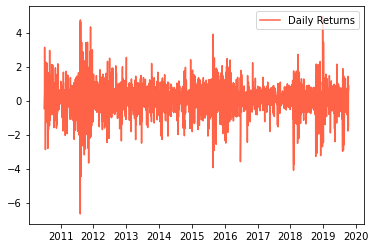

In [16]:
# Calculate daily returns as percentage price changes
sp_price['Return'] = 100 * (sp_price['Close'].pct_change())

# View the data
print(sp_price.head(10))

# plot the data
plt.plot(sp_price['Return'], color = 'tomato', label = 'Daily Returns')
plt.legend(loc='upper right')
plt.show()
# As shown in the plot, the market exhibited periods of high volatility followed by periods of low volatility.
# Next up, let's see how GARCH models tackle the challenge posed by volatility clustering.

In [19]:
# we are interested in the data from 2017/10/16

sp_data = sp_price.loc['2017-10-16':, :]
sp_data

,Close,Return
Date,,
2017-10-16,2557.64,0.175076
2017-10-17,2559.36,0.067249
2017-10-18,2561.26,0.074237
2017-10-19,2562.10,0.032796
2017-10-20,2575.21,0.511690
...,...,...
2019-10-04,2952.01,1.421685
2019-10-07,2938.79,-0.447830
2019-10-08,2893.06,-1.556083


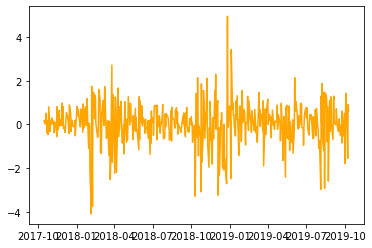

Daily volatility:  0.94%
Monthly volatility:  4.31%
Annual volatility:  14.92%


In [21]:
# Plot the price returns
plt.plot(sp_data['Return'], color = 'orange')
plt.show()

# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

In [22]:
# GARCH and ARCH model
# before GARCH there was another model called ARCH: Auto Regressive Conditional Heteroskedasticity, which means the data
# has time-dependent varying characteristics and unpredictable. 
# GARCH model was developed based on ARCH model: ARCH was develaoped by and American and GARCH by a Danich economist.

# before dive into GARCH model lets introduce some basic terms:
# White noise (z): a sequence of random variables that can not be predicted. these random variables has a mean of zero 
# and a finite variance. in other words, A time series in white noise if the variables are independent and identically
# distributed with a mean of zero.

# Residual: a residual is the difference between the observed value of a variable at time t and its predicted value 
# based on information available prior to time t. if the prediction model is working properly, successive residuals are 
# uncorrelated with each other, they constitute a white noise time series. in other words, the model has taken care of 
# all the predictable components of a time series, left only the unpredictable white noise part. 
# assume at time t we wat to predict the return r_t using information as of time t-1: μ_t = Expected[r_t ∣Info(t − 1)]
# as the prediction won't be pefecr there will be some error: Residual (prediction error) = r_t = μ_t + ϵ_t
# similarly we can predict the volatility of time t as the expected varianve given information known as of time t-1    
# Expected volatility = Var = σ^2 = Expected[(r_t − μ_t )^2 ∣ Info(t − 1)] 
# As discussed earlier, it the prediction model works well, the residual should equal to the volatility times a random 
# variable from a white noise process. ϵ_t = σ_t ∗ ζ(White Noise)
# now it comes down to how to predict the volatility at time t, lets see how ARCH and GARCH model tackle this.  

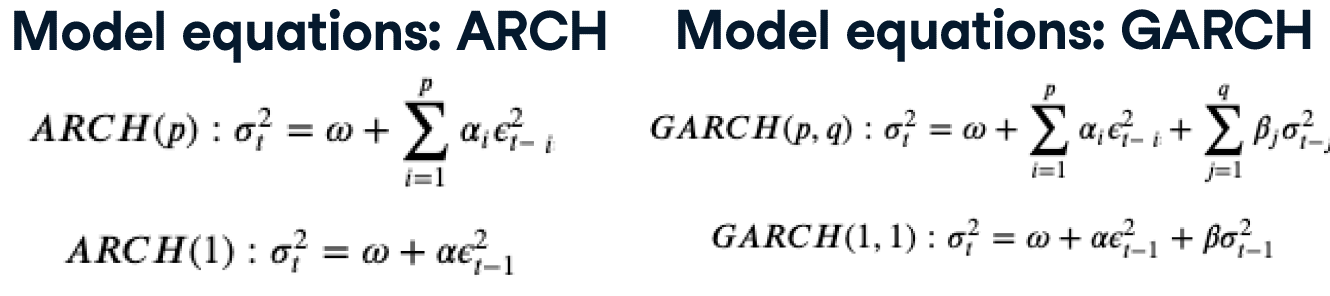

In [23]:
# the above equation in ARCH model with lag p, in fact it models variance as a weighted average of pasr residuals up to
# lag p. Hence ARCH(1) models states: variance of time t equals to a constant omega plus alpha times residual squared 
# of time t-1. 
# in practice, GARCH models are more commonly used by researchers. Besides p=periods lags of residualts, GARCH models 
# add q-period lags of variances for predicting the current variance. Hence a basic GARCH(1,1) model states: the 
# variance of time t is the sum of three components: a constant omega, alpha times residual squared of time t-1, and 
# beta times variance of time t-1. intuitively the model is auto regressive in nature, meaning that it tries to estimate
# the volatility at time t on the basis of information known as of time t-1. Second it estimates volatility as a 
# weighted average of past information. To make a GARCH(1,1) process realistic, there are two condistions: 
# 1- All parameters are non-negative, so the variance cannot be negative: ω, α, β >= 0
# 2- Model estimations are "mean-reverting" to the long-run variance: α + β < 1
# long-run variance= ω/(1 − α − β)
# the rule of thump regarding model parameter: 
# 1- The larger the α, the bigger the immediate impact of the shock, here shocks are expressed as reiduals or prediction 
# errors. 
# 2- if we keep the alpha fixed, The larger the β, the longer the duration of the impact, that is high or low volatility 
# periods tend to persist. 

In [24]:
# in summary: 
# Intuitively, GARCH variance forecast can be interpreted as a weighted average of three different variance forecasts.
# One is a constant variance that corresponds to the long run average. The second is the new information that was not 
# available when the previous forecast was made. The third is the forecast that was made in the previous period.
# The weights on these three forecasts determine how fast the variance changes with new information and how fast it 
# reverts to its long run mean.

In [27]:
# implement GARCH models in python

# import the relevant model
from arch import arch_model

# there are three steps to develop GARCH models
# 1- specify the model by defining model assumptions
# There are three types of assumptions to specify for a GARCH model
# first assumption: Distribution assumption of the residuals: 'normal'(default), 't', 'skewt', ...
# second assumption: mean model -> 'constant' (default), 'zero', 'AR':constant is most common for liquid financial asset 
# third assumption: Volatility model: "GARCH" (default), "ARCH" , "EGARCH", ...
# we will discuss the above assumptions above in more details later.

# 2- Then we fit the model with data
# 3- Use the fitted model to make a forecast

# Specify GARCH model assumptions
basic_gm = arch_model(sp_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     27,   Neg. LLF: 678.7434993661964
Iteration:      8,   Func. Count:     50,   Neg. LLF: 875.7928792353698
Iteration:     12,   Func. Count:     73,   Neg. LLF: 599.9984984639897
Optimization terminated successfully    (Exit mode 0)
            Current function value: 599.9984984639897
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


Iteration:      1,   Func. Count:      6,   Neg. LLF: 20021.465944394076
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1457433.8990556663
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2886.600579133578
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3798.073437458679
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2909.747941808212
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2779.3643008068457
Iteration:      7,   Func. Count:     47,   Neg. LLF: 5552.842057321014
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2783.7850577869744
Iteration:      9,   Func. Count:     59,   Neg. LLF: 2771.0217706939475
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2770.082392571153
Iteration:     11,   Func. Count:     70,   Neg. LLF: 2770.0821660473393
Iteration:     12,   Func. Count:     75,   Neg. LLF: 2770.082165044828
Iteration:     13,   Func. Count:     79,   Neg. LLF: 2770.0821650451053
Optimization terminated successfully    (Exit mode 0)
   

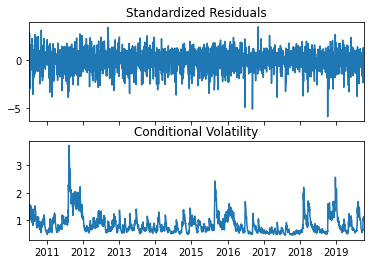

In [58]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit()

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot()
plt.show()

In [59]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5, reindex=True)

# Print the forecast variance
print(gm_forecast.variance[-1:])

# You just finished chapter 1! Notice in the output, the value in h.1 is a 1-step ahead forecast, while values in 
# h.2, …, h.5 are 2, …, 5-step ahead forecasts. Now you have gained hands-on experience with GARCH model.

                 h.1      h.2       h.3       h.4       h.5
Date                                                       
2019-10-10  0.994069  0.98828  0.982757  0.977488  0.972461


In [60]:
# Garch model assumptions
# distribution assumptions
# we want to see how we can define a better model by defining better assumptions.
# Volatility is not a directly observable quantity and is estimated through price return flactuations. 
# returns at t = r_t =  μ_t + ϵ_t and ϵ_t(residuals) are stochastic return shocks dependent on the size of the volatility. 
# therefore volatility is related to the residuals: ϵ_t = σ_t ∗ ζ(White Noise) so in order to know the volatility we need
# to know (assume) the distribution assumption of residuals and the mean of returns. So to define a good model we need to
# have assumptions most representative of actual data. 

In [61]:
# standardized residuals: Recall residuals are the differences between predicted returns and the mean returns. and the 
# standardized residuals = ϵ_t/σ_t
# by default the GARCH model assumes a normal distribution of the standardized residuals. But the financial world is 
# rarely that ideal. 

In [62]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_standard_deviation = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_standard_deviation
gm_std_resid

Date
2010-07-02   -0.428344
2010-07-06    0.394261
2010-07-07    2.864605
2010-07-08    0.544621
2010-07-09    0.440567
                ...   
2019-10-04    1.337137
2019-10-07   -0.491954
2019-10-08   -1.649300
2019-10-09    0.742119
2019-10-10    0.526976
Length: 2335, dtype: float64

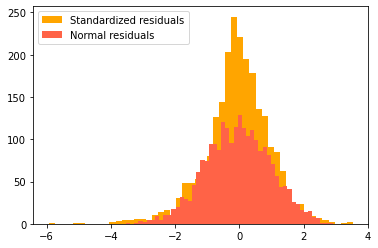

In [63]:
# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'Standardized residuals')

# genrate standard normal random numbers
normal_resid = np.random.normal(0, 1, 2335)

plt.hist(normal_resid, bins = 50, 
         facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

# Notice that compared with a standard normal distribution, the distribution curve of standardized residuals from the
# GARCH models exhibits more peaks, asymmetry, and has a negative skew.

Iteration:      1,   Func. Count:      8,   Neg. LLF: 87841.44304630479
Iteration:      2,   Func. Count:     19,   Neg. LLF: 165034.84129241406
Iteration:      3,   Func. Count:     28,   Neg. LLF: 13919.893530929236
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5499.372630507622
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4961.97072030221
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2732.0179634238934
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2729.30471802788
Iteration:      8,   Func. Count:     68,   Neg. LLF: 4989.136233666439
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2695.4641232129115
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2701.2979059430045
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2696.1086480530694
Iteration:     12,   Func. Count:    100,   Neg. LLF: 2688.805106009111
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2688.7683062009455
Iteration:     14,   Func. Count:    116,   Neg. LLF: 2688.

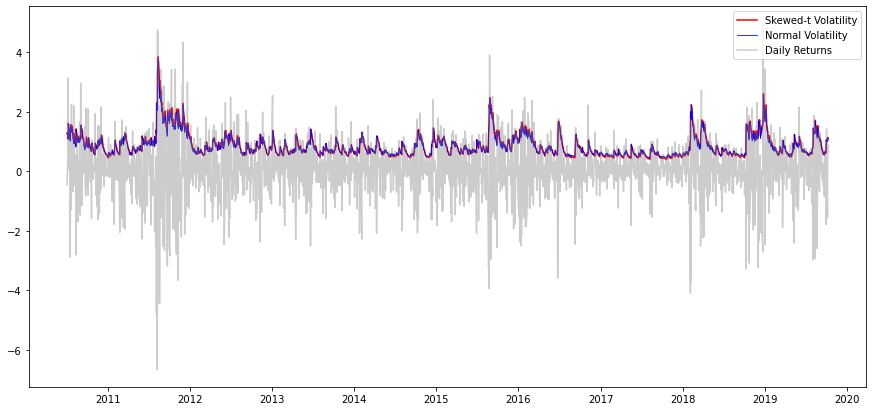

In [78]:
# Often times the financial data produce fat tails : large (positive or negative) returns under a normal distribution.
# the distribution curve also tend to exhibit skewness (assymetry). I order to deal with the fat tail we can use t-student
# distribution, and in order to handle the skewness of data we need to use skewed t distribution. 

# Specify GARCH model assumptions
skewt_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit()

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(15,7))

plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(gm_standard_deviation, color = 'blue', label = 'Normal Volatility', linewidth=0.8)
plt.plot(sp_price['Return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()
# As you can see with skewed Student’s t-distribution assumption, GARCH model estimation is more in line with the actual
# observations.

In [79]:
# Mean model specification
# by default GARCH model use a constant mean assumption, which generally works well with most of the common financial data.
# we can also specify a zero mean assumption, this is usefull if the mean of the time series has been modeled separately by
# another process, such as autoregressive (AR), moving-average(MA), or ARMA models, and we are using residuals from that 
# model to estimate volatility. Many practitioners prefer this approach to separate the process of mean and volatility 
# modeling. In addition we can choose to model the mean as an AutoRegressive process, so the current mean is correlated with
# the previous data: to do this you us "AR" in front of the mean parameter in the Garch model. 
# Due to the scope of this session we will not dive into autoregressive models such as AR, MA, or ARMA: if you are more 
# interested in these, check time series analysis in python in DataCamp

In [ ]:
# In practice, returns and volatility are modeled in separate processes. Typically the mean assumptions influence 
# predicted returns, but have a minor effect on the volatility estimations.

In [87]:
# Specify GARCH model assumptions
constant_mean_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
cmean_result = constant_mean_gm.fit(disp = 'off')
cmean_vol = cmean_result.conditional_volatility

# create another model this time with a mean of AR
AR_mean_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'AR', vol = 'GARCH', dist = 'normal')
armean_result = AR_mean_gm.fit(disp = 'off')
armean_vol = armean_result.conditional_volatility

# Print model summary of GARCH with constant mean
print(cmean_result.summary())
# Print model summary of GARCH with AR mean
print(armean_result.summary())





                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Tue, Aug 17 2021   Df Residuals:                     2334
Time:                        18:01:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

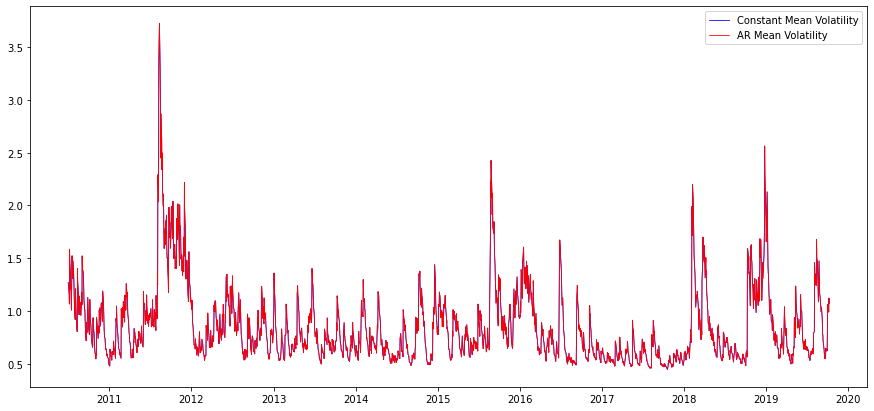

In [88]:

# Plot model volatility 
plt.figure(figsize=(15,7))
plt.plot(cmean_vol, color = 'blue', label = 'Constant Mean Volatility',linewidth=0.8)
plt.plot(armean_vol, color = 'red', label = 'AR Mean Volatility', linewidth=0.8)
plt.legend(loc = 'upper right')
plt.show()

In [89]:
# Check correlation of volatility estimations
print(np.corrcoef(cmean_vol, armean_vol)[0,1])

1.0


In [82]:
# from the above: The correlation coefficient is close to 1, and the plot shows volatility estimation from both models
# are very close. In fact, the impact of the mean model assumptions on volatility estimation is so small that, if the 
# interest is only in the volatility dynamics, usually one can just assume the most simple specification, namely the 
# constant mean model

In [85]:
# volatility models for asymmetric shocks.
# market tends to take the stairs up and the elevator down
# So far, GARCH models assume symmetric schocks on volatility, in other words positive or negative changes in price returns
# would have the same impact on volatility. What if this assumption does not hold?  in this session we want to see how to 
# model the asymmetric shocks on volatilty. 
# in the real financial world, market tends to take the stairs up and elevators down. When things are good, prices go up 
# slowly and steadily, but when things turn bad, like during a financial crisis, everyone panics and prices take a sharp 
# plunge. 
# the leverage effect refers to the observed tendency of an assets volatility to be negatively correlated with the asset's
# returns. So typically rising prices are accompanied by declining volatility and vice versa. An economic explanation of 
# this phenomenon is: as equity prices decline, companies have relatively less equity values compared to their debt values.
# Debt-Equity Ratio = Debt/Equity (Leverage Ratio), debt/equity goes up, the stock becomes riskier. 
# GJR-GARCH is developed to address the asymmetric shock effect on volatility.its equation is very similar to the standard
# GARCH model except it adds a conditional parameter: when the return shocks are negative, the conditional parameter will be
# included in the equation yo account for the additional impact. To use this GJR-ARCH we set o=1 in the model parameters. 
# Another popular model choice to address the asymmetric shock effect is the EGARCH model. E stands for Exponential since 
# EGARCH is based on log variance instead of variance itself. The actual equation is a bit complicated so we will skip the 
# nitty-gritty details. An intuitive takeaway is: EGARCH adds a conditional component to model the asymmetry in shocks 
# similar to the GJR-GARCH, also since the equation is based on log variance, it does not require non-negative constraints 
# on alpha, beta, therefore it works faster for likelihood maximization duirng model fitting. if you want to use 
# EGARCH: o=1, vol='EGARCH'


In [86]:
# both GJR-GARCH and EGARCH try to address the asymmetry shocks on volatility, which model is better depends on the data.
# in practice, try fitting different model with different assumptions, and select the one with the better performance. 
# in the next chapter we will see how to evalaute the performance of our model. 


In [92]:
# comare EGARCH and GJR-GARCH
# Specify model assumptions
jgr_garch_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
gjrgm_result = jgr_garch_gm.fit(disp = 'off')
gjrgm_vol = gjrgm_result.conditional_volatility

egarch_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
egarch_result = egarch_gm.fit(disp = 'off')
egarch_vol = egarch_result.conditional_volatility


# Print model fitting summary
print(gjrgm_result.summary())
print(egarch_result.summary())



                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2639.62
Distribution:      Standardized Student's t   AIC:                           5291.24
Method:                  Maximum Likelihood   BIC:                           5325.78
                                              No. Observations:                 2335
Date:                      Tue, Aug 17 2021   Df Residuals:                     2334
Time:                              18:07:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

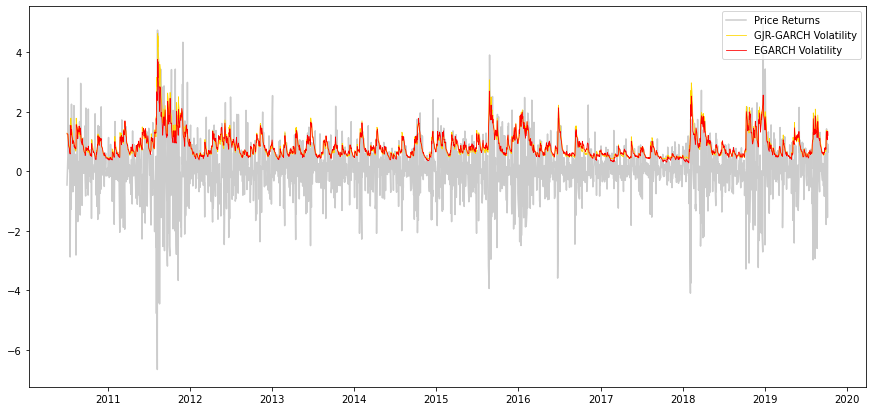

In [97]:
# Plot the actual Bitcoin returns
plt.figure(figsize=(15,7))

plt.plot(sp_price['Return'].dropna(), color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility', linewidth=0.8)

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility', linewidth=0.8)

plt.legend(loc = 'upper right')
plt.show()

# Overall both GJR-GARCH and EGARCH models did a good job of fitting the actual data. Comparatively. 
# Side Note: GJR-GARCH is more conservative in volatility estimation when applying it to the Bitcoin dataset.

In [98]:
# GARCH rolling window forecast
# an exciting part of financial modeling is making predictions, specifically want to perform rolling window forecast, where
# we use in-sample data for model fitting, perform 1-period ahead out-of-sample forecast and do this in a repeated fashion
# as time rolls forward. 
# there are two ways to perform a rolling window forecast:
# 1- Expanding window approach, which starts with a set of sample data, an as time moves forward, continuously add new data
#    to the sample. suppose we have 200 observations of a time series, first we estimate the model with the first 100 
#    observations to forcast the data point 101. then we include observation 101 into the sample to forecast the data point
#    102. the process is repeated until we have forecast for all 100 out-of-sample data points.
# Rolling window forecast is widely used because of the following motivations. 
# first when we use all the data to make estimation the model would have lookback bias. In reality we don't know the future, 
# the time series data used for model fitting and forecast should not overlap. Second the rolling window approach is less 
# subject to overfitting. An implicit time series model assumption is model parameters are stable over time, but this barely
# holds true in turbulent market environment. Imagine when we try to fit a GARCH(1,1) with observations from economic crisis
# versus normal market conditions, we are likely to obtain very different omega, alpha, beta results. Third, the rolling window
# approach can better adapt our forecast to changes, by continuously incorporating new observations to the model fitting and 
# forecast, we are more responsive to the most recent economic conditions, such as news, chenges in economic cylcles and etc. 
# 2- Fixed rolling window forecast: similarly it starts with a set of sample data, and as time moves forwar, new data points 
#    are added. the differenct with the previous approach is old data points are dropped from the sample simultaneously to 
#    maintain a fixed window size. 
# what size for window: A window size too wide include obsolete data points, leading to higher prediction bias, also known as
# overfitting. A window size too narrow may leave out data relavant to the current economic condition, leading to increased 
# prediction variance. In short, we should be mindful that the optimal window size is a trade-off to balance bias and variance.

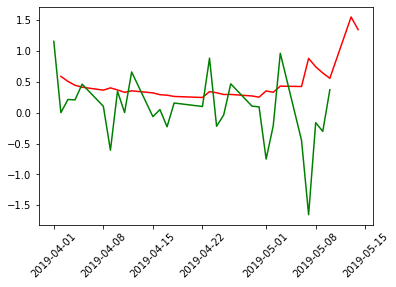

In [121]:
# Fixed rolling window forecast
start_loc = 1
end_loc = 2201
forecasts = {}
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5 , disp = 'off')
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1, reindex = True).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var_fixed = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.plot(forecast_var_fixed, color = 'red')
plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.xticks(rotation=45)
plt.show()
# As you can see the model did a decent job: variance predicted by our model fluctuates with the actual returns.

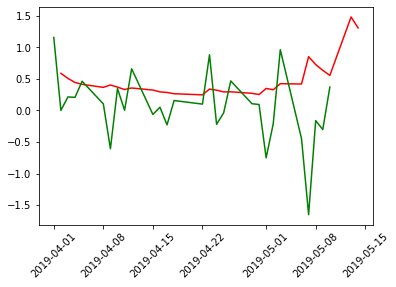

In [122]:
# Expanding window forecast
start_loc = 1
end_loc = 2201
forecasts = {}
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = start_loc, 
                             last_obs = i + end_loc, update_freq = 5 , disp = 'off')
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1, reindex = True).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var_expand = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.plot(forecast_var_expand, color = 'red')
plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.xticks(rotation=45)
plt.show()

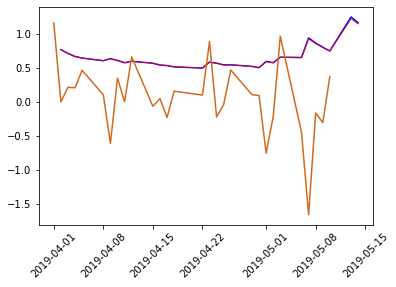

In [125]:
plt.plot(np.sqrt(forecast_var_fixed), color = 'blue')
plt.plot(np.sqrt(forecast_var_expand), color = 'red', linewidth = 0.8)
plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'chocolate')
plt.xticks(rotation=45)
plt.show()

In [126]:
# model performance evaluation
# KISS principle: A rule of thumb for data science modeling is "KISS" (keep it simple stupid). In other words, always
# choose a parsimonious model with parameters that are relevant. There are statistical tests and measures to help you 
# decide. you should try to drop irrelevant parameters and keep the ones that are statistically significant. 
# in order to know the significance of a parameter and decide if we should keep that parameter or not we can look at 
# either p-value or t-statistics. 


In [128]:
# Simplify the model with p-values
# The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level, the null
# hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(disp= 'off')


# Print model fitting summary
print(gm_result.summary())



                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Thu, Aug 19 2021   Df Residuals:                     2334
Time:                        12:02:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

In [129]:
# you can see the p-values and t-statistics from the above table, but if you want to show and use only p-values:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

# as you see all p-values for all parameters are exteremly low so all are statistically significant, which means that we
# should reject H0 (The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence
# level, the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not 
# necessary.)

          parameter        p-value
mu         0.077217   8.990332e-08
omega      0.039868   1.487366e-05
alpha[1]   0.169013   3.798304e-10
beta[1]    0.785058  2.240211e-182


In [130]:
# Simplify the model with t-statistics

# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})
# Print parameter stats
print(para_summary)

          parameter   std-err    t-value
mu         0.077217  0.014444   5.346032
omega      0.039868  0.009206   4.330551
alpha[1]   0.169013  0.026990   6.262099
beta[1]    0.785058  0.027260  28.798493


In [132]:
# we can also calculate t-values ourselves

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print calculated t-value
print(calculated_t)

# as you see the resual of t-statistic is consistent with p-values and all parameters are statistically significant.

mu           5.346032
omega        4.330551
alpha[1]     6.262099
beta[1]     28.798493
dtype: float64


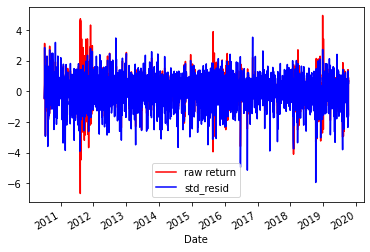

In [150]:
# Validation of GARCH models assumptions
# GARCH models make strict assumptions about the distribution characteristics of their standardized residuals. 
# If the model is doing a good job of explaining the data, the standardized residuals should resemble a white noise process
# , which does not exhibit data clustering or autocorrelation. 
# in this lesson lets see how to verify this.
# For starters we can do a visual check by plotting the standardized residuals. 
# as seen in the charts, the raw return data exhibits cleas signs of clustering. 
plt.plot(sp_price['Return'].dropna(), color = 'red', label = 'raw return')
gm_result.std_resid.plot(color='blue')
plt.legend()
plt.show()
# but after fitting the GARCH model, the standardized residuals do not show much clustering and are close to a random
# white noise movement. 

In [151]:
# we can also use autocorrelation to detect non-randomness in the standardized residuals. 
# Autocorrelation describe the correlation of a variable itself given a time lag, when there is a pattern such that values in
# the time series can be predicted based on preceding values in the series, the data exhibits autocorrelation. 
# Existence of auto correlation in the standardized residuals indicated the model is not working well and do not follow white
# noise process.
# we can use ACF plot or a statistical test such as Ljung-Box to detect auto correlations in the data. 

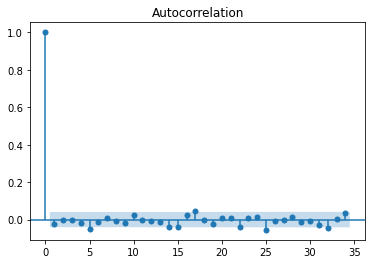

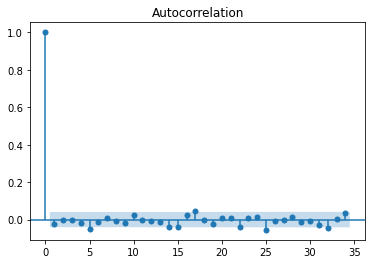

In [160]:
# ACF: AutoCorrelation Function
# The coeeficient between two values in a time series is called the Autocorrelation function (ACF), for example a lag 1 
# autocorrelation is the correlation between values that are one period apart. More genrally a lag k auto correlation is 
# the correlation between values that are k-period apart.
# an ACF plot is a visual representation of the autocorrelation by lags.
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(gm_result.std_resid, alpha = 0.05)   # alpha indicates the confidence lavel. 
#The ACF plot shows the majority of the data points are within the confidence interval,so the model is doing a decent job

In [158]:
# another way to detect autocorrelation
# Ljung-Box test
# Test whether any of a group of autocorrelations of a time series are di(erent from zero
# H0: the data is independently distributed
# P-value < 5%: the model is not sound (reject H0)

# in fact this test, instead of testing randomness at each distinct lag, it tests the overall
# randomness based on a number of lags. 

# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test 
lb_test = acorr_ljungbox(gm_result.std_resid , lags = 10, return_df = False) 
# use lags to set the maximum number of time lags up to which the test will be performen, here we get 10 p-values

# Check p-values
print('P-values are: ', lb_test[1])
# as you see all p-values are greater than 0.05 of confidence level, showing we can not reject H0 and the data is
# independently distributed.  In other words, no autocorrelations detected and the model is doing a decent job.

P-values are:  [0.22953206 0.48521637 0.68511361 0.71598143 0.16630508 0.22583321
 0.30264538 0.39337675 0.39983994 0.38763133]


In [161]:
# Goodness of fit:
# As the name suggests, "goodness of fit" describes how well a model fits a set of observations.
# measure of goodness of fit typically summerize the discrepancies between observed values and the values estimated by the
# model. There are many methods to measure the goodness of fit:
# 1- Maximum likelihood method
# 2- Information criteria


In [162]:
# Maximum likelihood
# GARCH models use the maximum likelihood method to estimate parameters. Maximum likelihood estimation is a method
# of estimating model parameters by maximizing the likelihood function, so that it maximizes the probability, or the
# likelihood of getting the data we have obsereved under the assumed model. 
# in the model summary we can see the log_likelihood:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Thu, Aug 19 2021   Df Residuals:                     2334
Time:                        12:02:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

In [163]:
# we can also the number directly:
print(gm_result.loglikelihood)

-2770.082165044828


In [165]:
# overfitting: overfitting happens when the model learns the details and noises in the training datal or in sample data.
# # to the extent that it negatively impacts the performance of the model on new data, or out of sample data. In other words,
# noise and random flactuations in the in-sample data is picked up and learned as patterns by the model, which does not apply
# to new information. Overfitting usually results from making an overly complex model to explain idiosyncrasies in the data 
# under study. 
# information criteria: intend to measure the trade off between goodness of fit and model complexity. when fitting models, it is
# possible to increase the likelihood by adding parameters, but doing so may result in overfitting. 
# information criteria consider the model likelihood, but also add penalties for model complexity. A model with more parameters 
# will have higher information criteria score given the same likelihood values. 
# AIC and BIC are two commonly used information criteria. 
# AIC: Akaike Information Criteria is name after statistician Akaike who formulated it. 
# BIC: Baysian Information Criteria and is quite similar to AIC. 
# they are both used underthe contxt of model selection snd the models with relatively low AIC or BIC scores are preferred. 
# diferrence between AIC and BIC: in general their results agree with each other, and their lower scores are preferred. The main 
# difference is the size of penalty for model complexity. BIC imposes bigger penalties on models with more parameters and leads to
# more parsimonious models than does AIC. 
# you can see AIC and BIC od GARCH models in the model summary. we can also get them directly:
print("AIC score:", gm_result.aic)
print('BIC score:', gm_result.bic)

AIC score: 5548.164330089656
BIC score: 5571.187398770067


In [167]:
t_student_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't')
# Fit the model
t_student_gm_result = t_student_gm.fit(disp= 'off')


# Print model fitting summary
print(t_student_gm_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2693.31
Distribution:      Standardized Student's t   AIC:                           5396.62
Method:                  Maximum Likelihood   BIC:                           5425.39
                                              No. Observations:                 2335
Date:                      Thu, Aug 19 2021   Df Residuals:                     2334
Time:                              18:40:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [180]:
print("log_likelihood for normal assumption    = ", gm_result.loglikelihood)
print("log_likelihood for t-student assumption = ", t_student_gm_result.loglikelihood)
# as you see t-student has a greater loglikelihood, so it is better in terms of log likelihood.

log_likelihood for normal assumption    =  -2770.082165044828
log_likelihood for t-student assumption =  -2693.3075049758595


In [181]:
# Print the AIC 
print('AIC of normal assumption model    :', gm_result.aic)
print('AIC of t-student assumption model :', t_student_gm_result.aic)

# Print the BIC
print('BIC of normal assumption model    :', gm_result.bic)
print('BIC of t-student assumption model :', t_student_gm_result.bic)
# in terms of information criteria, t-student is better because is has lower AIC and BIC

AIC of normal assumption model    : 5548.164330089656
AIC of t-student assumption model : 5396.615009951719
BIC of normal assumption model    : 5571.187398770067
BIC of t-student assumption model : 5425.393845802234


In [178]:
# GARCH model Backtesting
# in this part we learn how to use backtesting to ass model performance and how to quantify and compare backtesting results
# Backtesting is a method to assess the quality of a model forecast. we compare the model's predicted results with the 
# actual historical data to see how close they are. A satisfactory backtesting result will give us more confidence in the 
# reliability of model predictions. Typically we can seperate all the historical data we hace at hand into two parts. The 
# so-called "in-sample" data is used for modeling fitting, and the "out of sample" data is reserved for backtesting to 
# to evaluate the model performance. We can use MAE to measure backtesting results. 
# MAE: Mean Absolute Error: (1/N)*sum|yi-mean| the smaller the better
# MSE: Mean Square Error: (1/N)sum(yi-mean)^2 , the smaller the better

# Lets import our real and predicted variances using our garch model (in practice we need to calculate them by ourselves)
# but here i did not know how to calcualte them, thats why I just downloaded the predifined data
data = pd.ExcelFile("F:\\schulich\\datacamp\\applied finance\\4- GARCH Models in Python\\actual and predicted var.xlsx")
                             

actual_var = pd.read_excel(data, 'actual_var', parse_dates=['Date'], index_col='Date')
forecast_var = pd.read_excel(data, 'forecast_var',  parse_dates=['Date'], index_col='Date')
actual_var.head() 

,ActualVar
Date,
2019-06-28,0.284698
2019-07-01,0.525707
2019-07-02,0.062822
2019-07-03,0.525719
2019-07-05,0.049620


In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE) : {:.3g}'.format(mse))
    return mae, mse

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var)

# MSE is usually larger than MAE due to the squared effect. 

Mean Absolute Error (MAE): 0.802
Mean Squared Error (MSE) : 2.37


(0.8023970666666665, 2.373372239134867)

In [183]:
# GARCH Models in action
# VaR in financial risk management
# VaR is an important concept in risk managment to quantify the potential losses. 
# VaR is always discussed with three ingredients: 1- portfolio 2- time horizon 3- probability : example: 1-day 5% $1M VaR
# the above VaR give us the dollar amount of potential minimum potential loss of our $1M portfoilio with 5% probability.
# When the portfolio loss exceeeds the VaR, it is called VaR exceedance. if our probability is 5%, the number or time that
# exceedance happens during a year should be less than 13 times, because 13/250(number of trade days a year) = 5%. if the 
# number is more than 13, it means that our model to calculate VaR is underestimating the risk. 


In [184]:
# Dynamic VaR with GARCH
# during financial crisis, volatility clusters and losses tend to occur several days in a row. GARCH models incorporate the
# time varying characteristic of volatility, hence enable us to make more realistic VaR estimation:
# VaR = portfolio expected mean return + a quantile based on our confidence level * (GARCH volatility)
# there differnet ways to obtain the quantile: Parametice VaR (using distributio), Empirical VaR (using histiorical data)

In [192]:
# VaR with GARCH volatility and parmetric quantile 
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(disp= 'off')


# Make forecast
gm_forecast = gm_result.forecast(start = '2018-10-10', reindex= False)
# get mean and Variance forecast
mean_forecast = gm_forecast.mean['2018-10-10':]
variance_forecast = gm_forecast.variance['2018-10-10':]
variance_forecast

,h.1
Date,
2018-10-10,2.203659
2018-10-11,2.539923
2018-10-12,2.338881
2018-10-15,1.951379
2018-10-16,2.297660
...,...
2019-10-04,1.139064
2019-10-07,0.980692
2019-10-08,1.260638


In [193]:
mean_forecast

,h.1
Date,
2018-10-10,0.077217
2018-10-11,0.077217
2018-10-12,0.077217
2018-10-15,0.077217
2018-10-16,0.077217
...,...
2019-10-04,0.077217
2019-10-07,0.077217
2019-10-08,0.077217


5% parametric quantile:  -1.6448536269514729


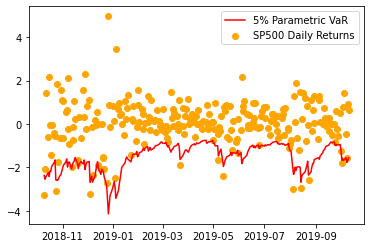

In [195]:
# Obtain the parametric quantile
q_parametric = basic_gm.distribution.ppf(0.05)

print('5% parametric quantile: ', q_parametric)
    
# Calculate the VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric

# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,sp_price.Return['2018-10-10':], color = 'orange', label = 'SP500 Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

5% parametric quantile:  -1.5589027087968312


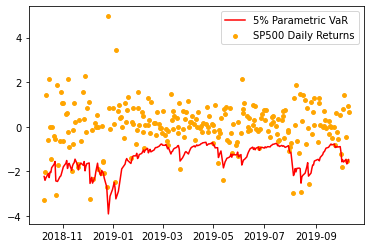

In [209]:
# lets compare with t-distribution assumption
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't')
# Fit the model
gm_result = basic_gm.fit(disp= 'off')
# Make forecast
gm_forecast = gm_result.forecast(start = '2018-10-10', reindex= False)
# Obtain the parametric quantile
q_parametric = basic_gm.distribution.ppf(0.05, gm_result.params.nu)

print('5% parametric quantile: ', q_parametric)
    
# Calculate the VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric

# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,sp_price.Return['2018-10-10':], color = 'orange', label = 'SP500 Daily Returns' ,s=15)
plt.legend(loc = 'upper right')
plt.show()

In [203]:
std_resid = gm_result.std_resid


5% empirical quantile:  -1.714510041469595


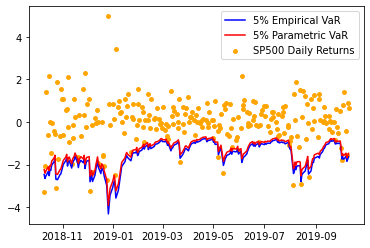

In [208]:
# VaR with GARCH volatility and historical quantile 
# Obtain the empirical quantile
q_empirical = std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Calculate the VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
# Save VaR in a DataFrame
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot the VaRs
plt.plot(VaR_empirical, color = 'blue', label = '5% Empirical VaR')
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,sp_price.Return['2018-10-10':], color = 'orange', label = 'SP500 Daily Returns', s=15)
plt.legend(loc = 'upper right')
plt.show()
#  Overall both VaRs are very close, but the empirical VaRs have bigger loss estimations, which implies VaRs based on the
# theoretical normal-distribution assumption may underestimate the downside risks.

In [237]:
# Dynamic covariance in portfolio optimization
# covariamce is a statistical tool used to determine the relationship of movement between two variables. in finance the 
# varriables can be price of different assets. 

# Compute GARCH covariance

FXrates = pd.read_excel("F:\\schulich\\datacamp\\applied finance\\4- GARCH Models in Python\\Excelrates.xlsx",
                             parse_dates=['Date'], index_col='Date')
FXrates

,EURUSD,USDCAD
Date,,
2009-01-01,1.4045,1.2201
2009-01-02,1.3921,1.2050
2009-01-05,1.3635,1.1890
2009-01-06,1.3536,1.1842
2009-01-07,1.3644,1.1940
...,...,...
2019-11-19,1.1078,1.3268
2019-11-20,1.1073,1.3304
2019-11-21,1.1059,1.3285


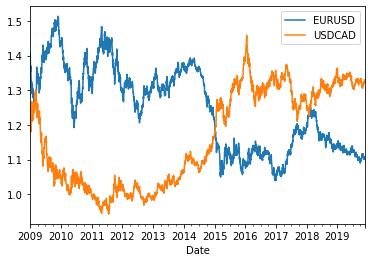

In [238]:
FXrates.plot()
plt.show()

In [245]:
FXratesReturns = FXrates
FXratesReturns['EURUSD return'] = FXratesReturns['EURUSD'].pct_change().dropna()*100
FXratesReturns['USDCAD return'] = FXratesReturns['USDCAD'].pct_change().dropna()*100
FXratesReturns = FXratesReturns.dropna()
FXratesReturns

,EURUSD,USDCAD,EURUSD return,USDCAD return
Date,,,,
2009-01-02,1.3921,1.2050,-0.882876,-1.237603
2009-01-05,1.3635,1.1890,-2.054450,-1.327801
2009-01-06,1.3536,1.1842,-0.726073,-0.403701
2009-01-07,1.3644,1.1940,0.797872,0.827563
2009-01-08,1.3702,1.1797,0.425095,-1.197655
...,...,...,...,...
2019-11-19,1.1078,1.3268,0.054191,0.469484
2019-11-20,1.1073,1.3304,-0.045135,0.271330
2019-11-21,1.1059,1.3285,-0.126434,-0.142814


In [247]:
# step 1: fit GARCH models and obtain volatility for each return series
gm_model_eur = arch_model(FXratesReturns['EURUSD return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't', rescale= False)
gm_model_cad = arch_model(FXratesReturns['USDCAD return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't', rescale= False)
# Fit the model
gm_eur = gm_model_eur.fit(disp= 'off')
gm_cad = gm_model_cad.fit(disp= 'off')

# gm_eur, gm_cad are fitted GARCH models
vol_eur = gm_eur.conditional_volatility
vol_cad = gm_cad.conditional_volatility

print(vol_eur, vol_cad)

Date
2009-01-02    1.066356
2009-01-05    1.060144
2009-01-06    1.104638
2009-01-07    1.093741
2009-01-08    1.085056
                ...   
2019-11-19    0.288477
2019-11-20    0.284622
2019-11-21    0.280708
2019-11-22    0.277603
2019-11-25    0.280240
Name: cond_vol, Length: 2842, dtype: float64 Date
2009-01-02    1.158535
2009-01-05    1.160012
2009-01-06    1.165360
2009-01-07    1.142992
2009-01-08    1.129989
                ...   
2019-11-19    0.276888
2019-11-20    0.287769
2019-11-21    0.288140
2019-11-22    0.285265
2019-11-25    0.281927
Name: cond_vol, Length: 2842, dtype: float64


In [248]:
# Step 2: Compute standardized residuals from the fitted GARCH model
resid_eur = gm_eur.resid/vol_eur
resid_cad = gm_cad.resid/vol_cad

print(resid_eur, resid_cad)

Date
2009-01-02   -0.820767
2009-01-05   -1.930685
2009-01-06   -0.650373
2009-01-07    0.736480
2009-01-08    0.398819
                ...   
2019-11-19    0.214356
2019-11-20   -0.131713
2019-11-21   -0.423172
2019-11-22   -1.210239
2019-11-25   -0.199361
Length: 2842, dtype: float64 Date
2009-01-02   -1.074672
2009-01-05   -1.151060
2009-01-06   -0.352803
2009-01-07    0.717521
2009-01-08   -1.066468
                ...   
2019-11-19    1.668692
2019-11-20    0.917009
2019-11-21   -0.521471
2019-11-22    0.422490
2019-11-25   -0.106394
Length: 2842, dtype: float64


In [250]:
# Step 3: Compute ρ as simple correlation of standardized residuals
corr = np.corrcoef(resid_eur, resid_cad)[0,1]
print('Correlation: ', corr)

Correlation:  -0.43877562112742424


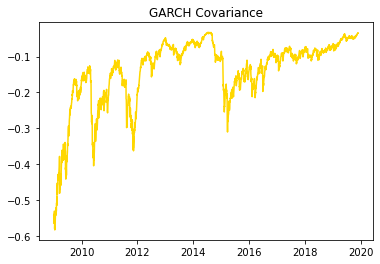

In [251]:
# Step 4: Compute GARCH covariance by multiplying the correlation and volatility.
# Calculate GARCH covariance
covariance =  covariance = corr * vol_eur * vol_cad

# Plot the data
plt.plot(covariance, color = 'gold')
plt.title('GARCH Covariance')
plt.show()
# Notice the EUR/USD and USD/CAD rates tend to move in the opposite directions, so their dynamic covariance is negative 
# and fluctuating over time.

In [252]:
variance_eur = vol_eur**2
variance_cad = vol_cad**2

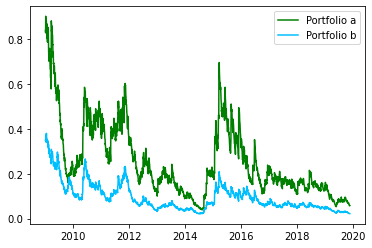

In [253]:
# Define weights
Wa1 = 0.9
Wa2 = 1 - Wa1
Wb1 = 0.5
Wb2 = 1 - Wb1

# Calculate portfolio variance
portvar_a = Wa1**2 * variance_eur + Wa2**2 * variance_cad + 2*Wa1*Wa2 *covariance
portvar_b = Wb1**2 * variance_eur + Wb2**2 * variance_cad + 2*Wb1*Wb2*covariance

# Plot the data
plt.plot(portvar_a, color = 'green', label = 'Portfolio a')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Portfolio b')
plt.legend(loc = 'upper right')
plt.show()
# Portfolio b is much less volatile compared to portfolio a. Even just for a simple two-asset portfolio, how you structure
# it can greatly alter the risk profile.

In [254]:
# Dynamic Beta in portfolio management
# beta is a measure of systematic risk that can not be reduced by diversification.
# the correlation and volatility for calculating the beta is derived from our GARCH model.
data = pd.read_excel("F:\\schulich\\datacamp\\applied finance\\4- GARCH Models in Python\\sp500 and tesla.xlsx",
                             parse_dates=['Date'], index_col='Date')
data

,TSLA,SPX
Date,,
2010-06-29,4.778,1041.24
2010-06-30,4.766,1030.71
2010-07-01,4.392,1027.37
2010-07-02,3.840,1022.58
2010-07-06,3.222,1028.06
...,...,...
2019-10-04,46.286,2952.01
2019-10-07,47.544,2938.79
2019-10-08,48.010,2893.06


In [255]:
data['tesla return'] = data['TSLA'].pct_change().dropna()*100
data['sp500 return'] = data['SPX'].pct_change().dropna()*100
data = data.dropna()
data

,TSLA,SPX,tesla return,sp500 return
Date,,,,
2010-06-30,4.766,1030.71,-0.251151,-1.011294
2010-07-01,4.392,1027.37,-7.847251,-0.324048
2010-07-02,3.840,1022.58,-12.568306,-0.466239
2010-07-06,3.222,1028.06,-16.093750,0.535899
2010-07-07,3.160,1060.27,-1.924271,3.133086
...,...,...,...,...
2019-10-04,46.286,2952.01,-0.686607,1.421685
2019-10-07,47.544,2938.79,2.717884,-0.447830
2019-10-08,48.010,2893.06,0.980145,-1.556083


In [257]:
# step 1: fit GARCH models and obtain volatility for each return series
gm_model_tesla = arch_model(data['tesla return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't', rescale= False)
gm_model_sp500 = arch_model(data['sp500 return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 't', rescale= False)
# Fit the model
gm_tesla = gm_model_tesla.fit(disp= 'off')
gm_sp500 = gm_model_sp500.fit(disp= 'off')


teslaGarch_vol = gm_tesla.conditional_volatility
spGarch_vol = gm_sp500.conditional_volatility

print(teslaGarch_vol , spGarch_vol)

Date
2010-06-30    6.415198
2010-07-01    6.265827
2010-07-02    6.287323
2010-07-06    6.555251
2010-07-07    7.040225
                ...   
2019-10-04    3.066164
2019-10-07    3.023920
2019-10-08    3.016644
2019-10-09    2.976847
2019-10-10    2.951436
Name: cond_vol, Length: 2337, dtype: float64 Date
2010-06-30    1.238500
2010-07-01    1.216284
2010-07-02    1.121112
2010-07-06    1.048599
2010-07-07    0.977397
                ...   
2019-10-04    1.023347
2019-10-07    1.089654
2019-10-08    1.019611
2019-10-09    1.155362
2019-10-10    1.108847
Name: cond_vol, Length: 2337, dtype: float64


In [259]:
teslaGarch_resid = gm_tesla.resid/teslaGarch_vol
spGarch_resid = gm_sp500.resid/spGarch_vol

print(teslaGarch_resid , spGarch_resid)

Date
2010-06-30   -0.057192
2010-07-01   -1.270862
2010-07-02   -2.017401
2010-07-06   -2.472750
2010-07-07   -0.289766
                ...   
2019-10-04   -0.261680
2019-10-07    0.860518
2019-10-08    0.286543
2019-10-09    0.588048
2019-10-10   -0.010120
Length: 2337, dtype: float64 Date
2010-06-30   -0.882864
2010-07-01   -0.333952
2010-07-02   -0.489132
2010-07-06    0.432736
2010-07-07    3.121508
                ...   
2019-10-04    1.308992
2019-10-07   -0.486359
2019-10-08   -1.606707
2019-10-09    0.716938
2019-10-10    0.504522
Length: 2337, dtype: float64


In [261]:
correlation = np.corrcoef(teslaGarch_resid, spGarch_resid)[0,1]
print('Correlation: ', correlation)

Correlation:  0.35917571745957494


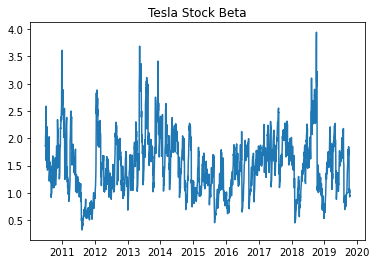

In [262]:
# Compute the Beta for Tesla
stock_beta = correlation * (teslaGarch_vol / spGarch_vol)

# Plot the Beta
plt.title('Tesla Stock Beta')
plt.plot(stock_beta)
plt.show()